# Air Quality model prediction

In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

In [2]:
data_files = [
    "january_2018_sensor_data_archive.csv",
    "february_2018_sensor_data_archive.csv",
    "march_2018_sensor_data_archive.csv",
]
df_list = []
for i in data_files:
    df_list.append(pd.read_csv(i, sep=";", index_col="timestamp", parse_dates=True))
    print(i, "Loaded")

january_2018_sensor_data_archive.csv Loaded
february_2018_sensor_data_archive.csv Loaded
march_2018_sensor_data_archive.csv Loaded


In [3]:
df = pd.concat(df_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 346484 entries, 2018-01-01 00:00:04.053149+00:00 to 2018-03-31 23:59:14.859934+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    346484 non-null  int64  
 1   sensor_type  346484 non-null  object 
 2   location     346484 non-null  int64  
 3   lat          346484 non-null  float64
 4   lon          346484 non-null  float64
 5   value_type   346484 non-null  object 
 6   value        346484 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 21.1+ MB


In [4]:
df.head()

,sensor_id,sensor_type,location,lat,lon,value_type,value
timestamp,,,,,,,
2018-01-01 00:00:04.053149+00:00,29,SDS011,11,-6.818,39.285,P2,9.27
2018-01-01 00:00:04.053149+00:00,29,SDS011,11,-6.818,39.285,P1,24.30
2018-01-01 00:00:46.551725+00:00,33,SDS011,11,-6.818,39.285,P1,15.63
2018-01-01 00:00:46.551725+00:00,33,SDS011,11,-6.818,39.285,P2,7.70
2018-01-01 00:00:48.041659+00:00,34,DHT22,11,-6.818,39.285,humidity,71.40


In [5]:
df["value_type"].value_counts()
df["sensor_type"].value_counts()

sensor_type
SDS011    252492
DHT22      93992
Name: count, dtype: int64

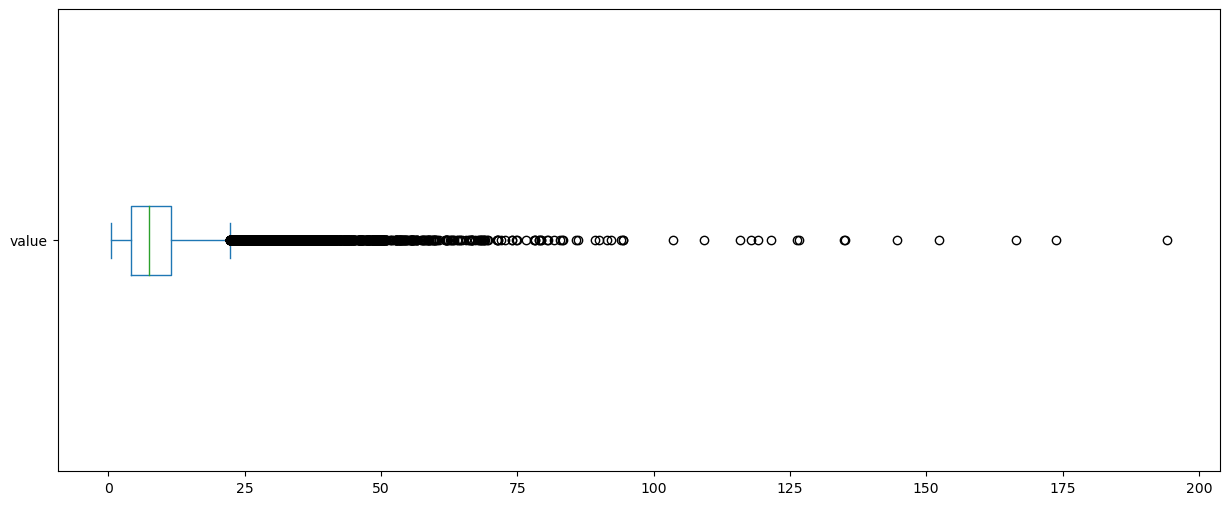

In [6]:
# for finding outliers
fig, ax = plt.subplots(figsize=(15, 6))
df[df["value_type"] == "P2"]["value"].plot(kind="box", vert=False, ax=ax);

# Data wrangling

In [28]:
def wrangle(df):
    # Data wrangling
    
    # Get the P2 readings only
    df = df[df["value_type"] == "P2"]
    
    # Localize the time zone
    df.index = df.index.tz_convert("Africa/Dar_es_Salaam")
    
    # Drop high cardinality or unimportant columns
    
    df = df["value"].rename("P2", inplace=True)
    
    # Remove outliers (if any)
    df = df[df <= 100]
    
    # Group the data by hour
    df = df.resample("1h").mean().fillna(method="ffill")
    
    return df

In [29]:
clean_data = wrangle(df)
clean_data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2160 entries, 2018-01-01 03:00:00+03:00 to 2018-04-01 02:00:00+03:00
Freq: H
Series name: P2
Non-Null Count  Dtype  
--------------  -----  
2160 non-null   float64
dtypes: float64(1)
memory usage: 33.8 KB


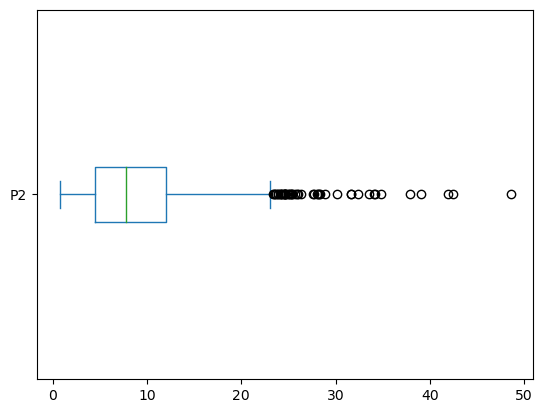

In [30]:
clean_data.plot(kind="box", vert=False);

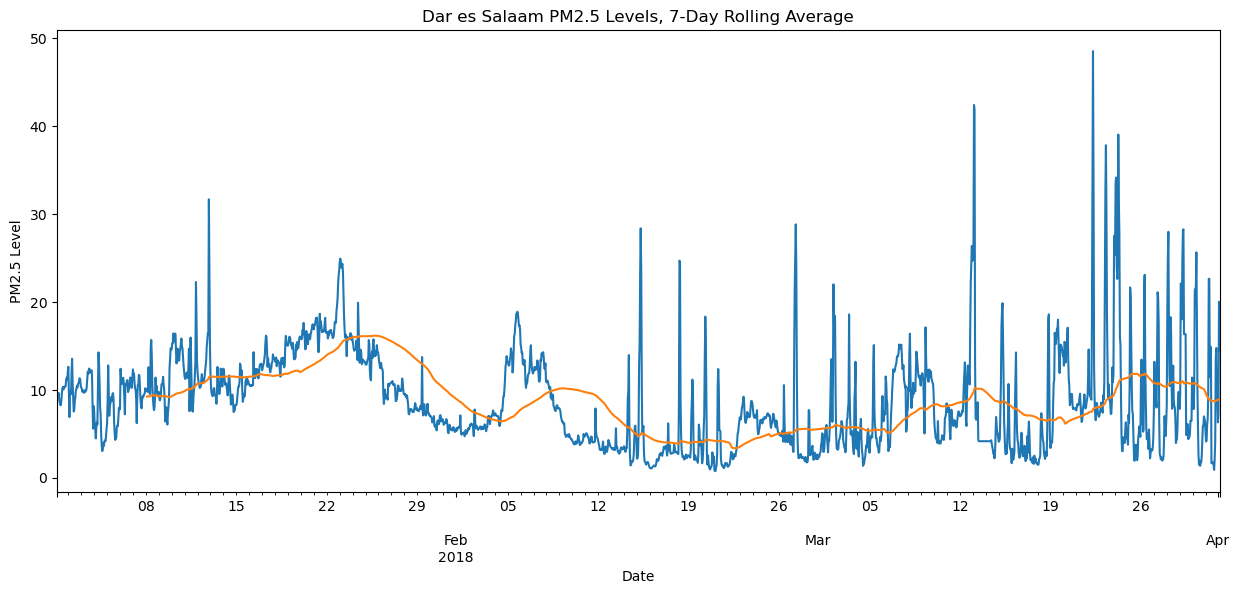

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
clean_data.plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salam PM2.5 Level");
clean_data.rolling(24*7).mean().plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels, 7-Day Rolling Average");

The data doesn't seem to be fully stationary, so we better consider differencing

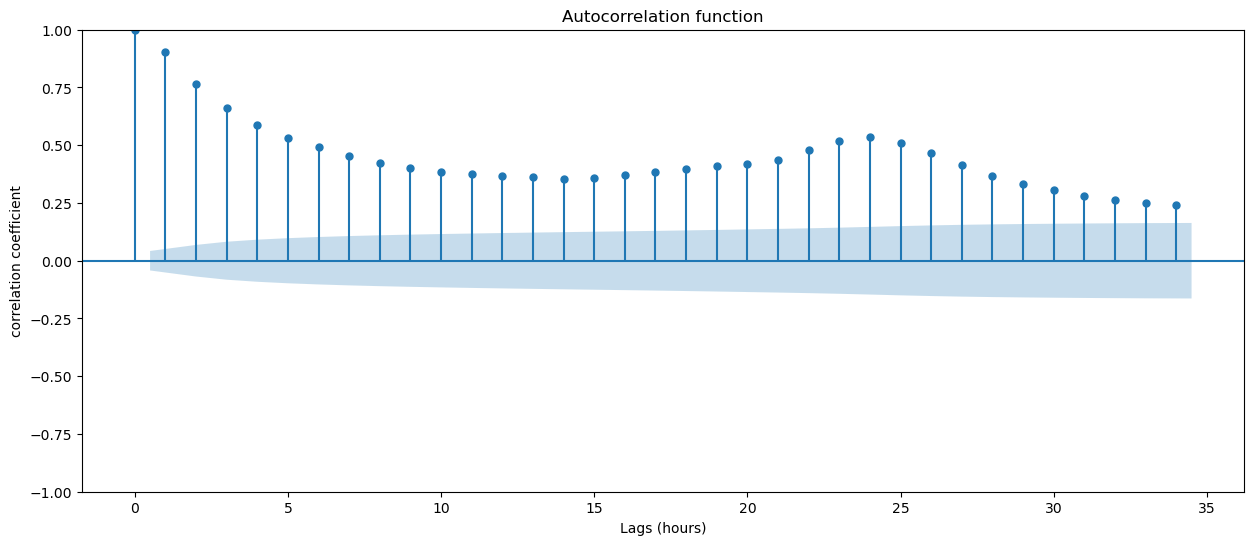

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(clean_data, ax=ax)
plt.xlabel("Lags (hours)")
plt.ylabel("correlation coefficient")
plt.title("Autocorrelation function");

The autocorrelation function decays slowly, therefore the data needs to be stationary

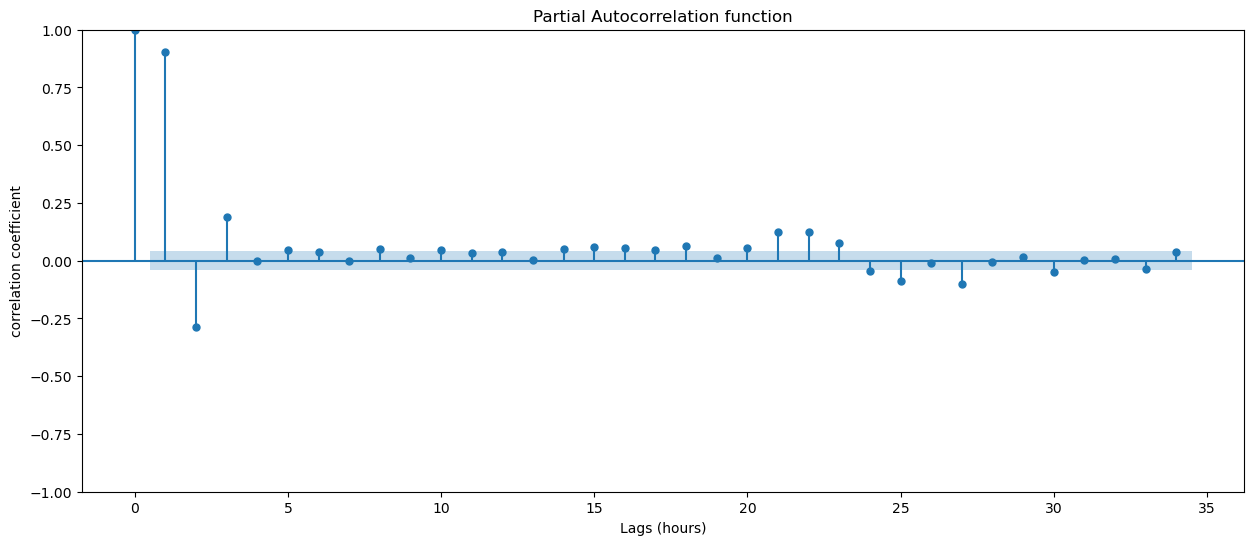

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(clean_data, ax=ax)
plt.xlabel("Lags (hours)")
plt.ylabel("correlation coefficient")
plt.title("Partial Autocorrelation function");

Based on the graph, we should consider AR parameter to be from 1 to 30

In [34]:
diff_data = clean_data.diff(1).dropna()
diff_data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2159 entries, 2018-01-01 04:00:00+03:00 to 2018-04-01 02:00:00+03:00
Freq: H
Series name: P2
Non-Null Count  Dtype  
--------------  -----  
2159 non-null   float64
dtypes: float64(1)
memory usage: 33.7 KB


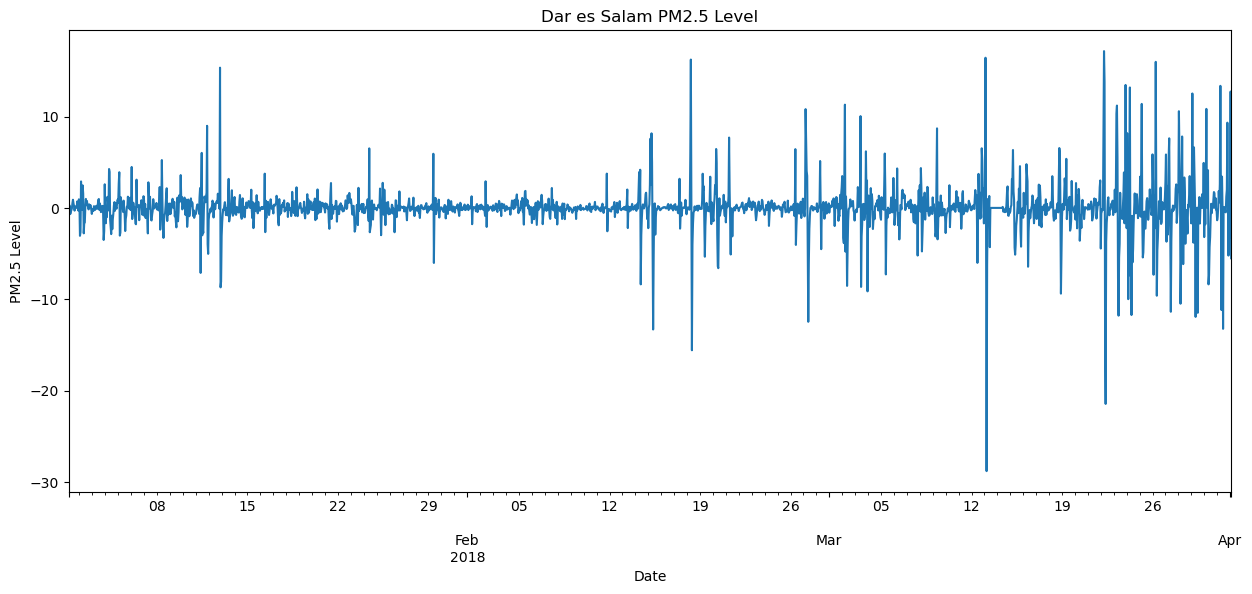

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
diff_data.plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salam PM2.5 Level");

The data has become stationary, so we continue

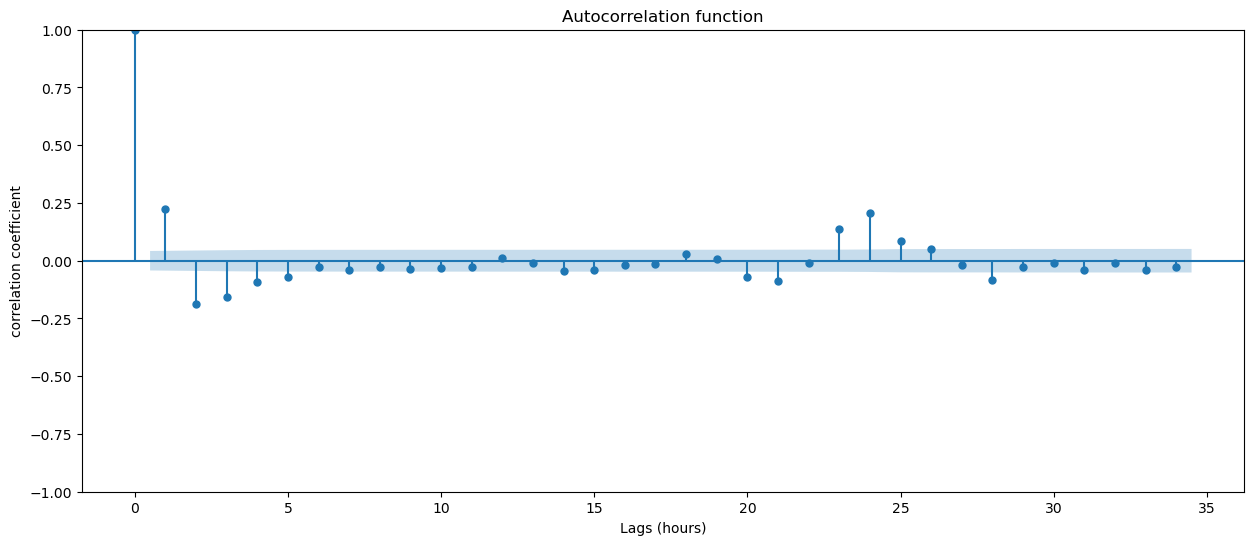

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(diff_data, ax=ax)
plt.xlabel("Lags (hours)")
plt.ylabel("correlation coefficient")
plt.title("Autocorrelation function");

from the figure above, we choose p to be in (0, 5)

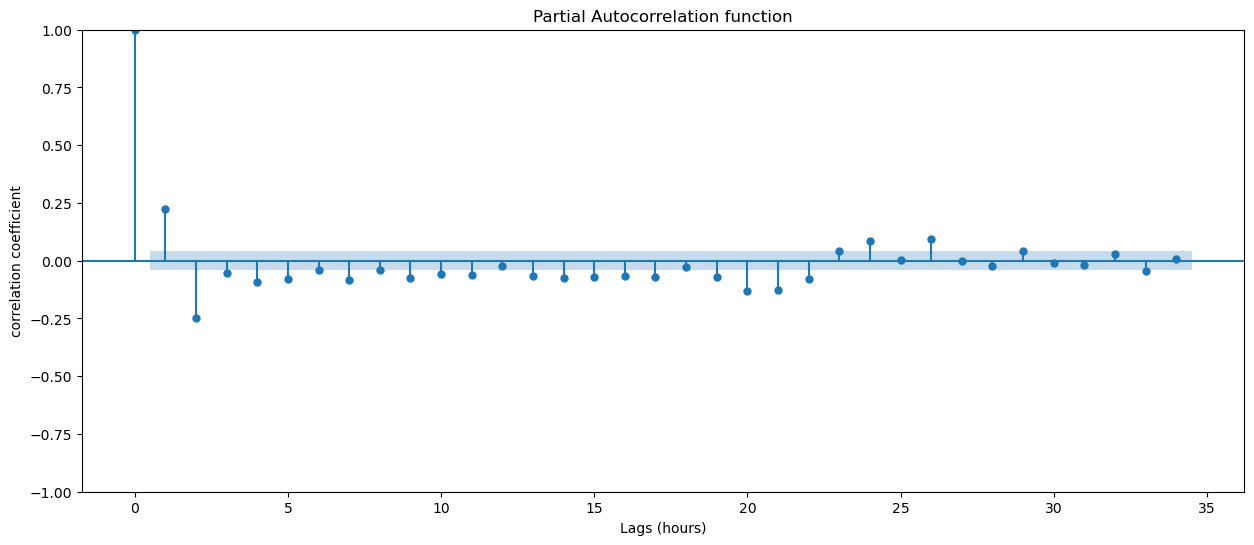

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(diff_data, ax=ax)
plt.xlabel("Lags (hours)")
plt.ylabel("correlation coefficient")
plt.title("Partial Autocorrelation function");

from the figure above, we choose p to be in range (0, 2)

# Spliting the Data

In [38]:
cutoff = int(len(clean_data) * 0.9)
y_train = clean_data.iloc[:cutoff]
y_test = clean_data.iloc[cutoff:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1944,)
y_test shape: (216,)


# Basline model

In [39]:
y_train_mean = y_train.mean()
y_pred_base = [y_train_mean] * len(y_train)
mae_base = mean_absolute_error(y_train, y_pred_base)
print("Mean of P2.5 Readings:", y_train_mean.round(4))
print("Baseline MeanAbsoluteError:", mae_base.round(4))

Mean of P2.5 Readings: 8.6235
Baseline MeanAbsoluteError: 4.0681


# Hypertuning

In [40]:
p_range = range(0, 3) # AR 2 lags
d = 1 # Integrated parameter
q_range = range(0, 6) # MA 5 past errors

mae_grid = dict()
for p in p_range:
    mae_grid[p] = list()
    for q in q_range:
        model = ARIMA(y_train, order=(p,d,q)).fit()
        mae_grid[p].append(mean_absolute_error(y_train, model.predict()))
print(mae_grid)

{0: [0.9378540050536928, 0.9041436955316565, 0.918519052815214, 0.9490120339221635, 0.9617473962147769, 0.95917049642756], 1: [0.9009179268855496, 0.908424045887944, 0.949178377065005, 0.9494378008558598, 0.9492023299894784, 0.9491455079500745], 2: [0.920888086567181, 0.9509503370303604, 0.949218475209282, 0.9490664705006266, 0.9490962599347751, 0.9491360658589625]}


        0       1       2
0  0.9379  0.9009  0.9209
1  0.9041  0.9084  0.9510
2  0.9185  0.9492  0.9492
3  0.9490  0.9494  0.9491
4  0.9617  0.9492  0.9491
5  0.9592  0.9491  0.9491


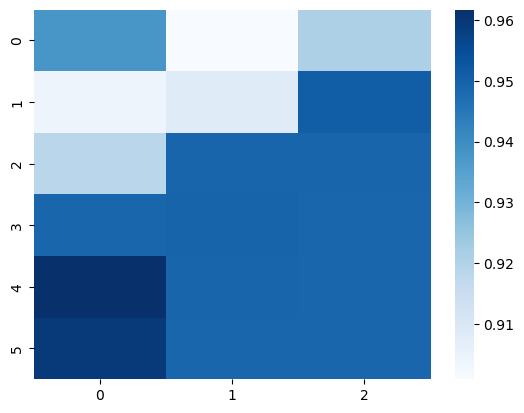

In [41]:
mae_df = pd.DataFrame(mae_grid).round(4)
print(mae_df)
sns.heatmap(mae_df, cmap="Blues");

# Best Model (IMA)

In [42]:
d = 1
p = mae_df.min().idxmin() # Get column with minimum value
q = mae_df[p].idxmin() # Get row with minimum value in that column
best_params = (p, d, q)
print("best params:", best_params)

model = ARIMA(y_train, order=best_params).fit()
mae_best = mean_absolute_error(y_train, model.predict())
print("mean_absolute_error Best model:", mae_best.round(4))

best params: (1, 1, 0)
mean_absolute_error Best model: 0.9009


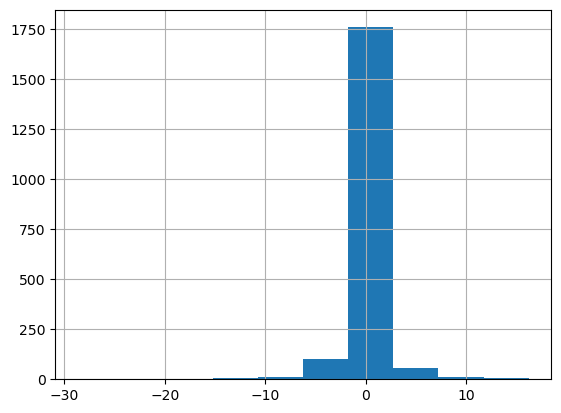

In [43]:
model.resid.hist();

# Walk Forward Validation

In [44]:
len_test = len(y_test)
history = y_train.copy()
y_pred = pd.Series(dtype=float)
print(len_test, "to go")

for i in range(len_test):   
    model = ARIMA(history, order=best_params).fit()
    next_pred = model.forecast()
    idx = next_pred.index[0]
    y_pred[idx] = next_pred
    history[idx] = y_test[idx]

y_pred.name = "predictions"
y_pred.index.name = "timestamp"
y_pred = y_pred.astype(float)

216 to go


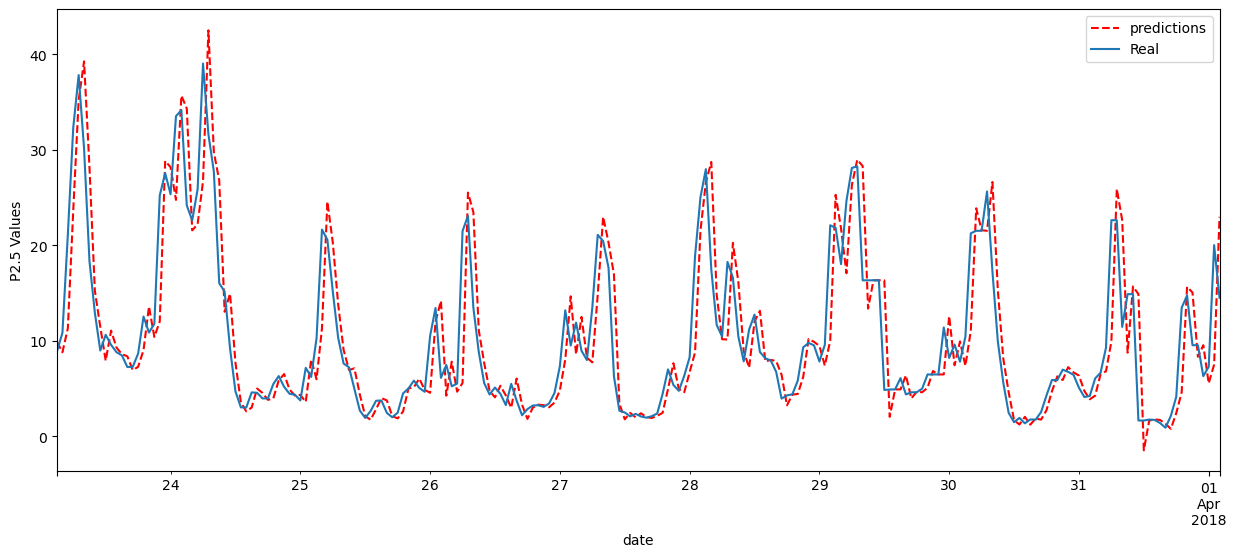

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))
y_pred.plot(ax=ax, linestyle="--", color="r")
y_test.plot(ax=ax)
plt.xlabel("date")
plt.ylabel("P2.5 Values")
plt.legend(["predictions", "Real"]);

In [46]:
mae_wfv = mean_absolute_error(y_test, y_pred)
print("mean_absolute_error fwv:", mae_wfv.round(4))

mean_absolute_error fwv: 2.9399


In [47]:
# Calculate the mean of your actual target values
mean_pm25 = clean_data.mean()

# Calculate the error as a percentage of the mean
error_percentage = (mae_wfv / y_train_mean) * 100

print(f"Mean PM2.5: {y_train_mean:.2f} µg/m³")
print(f"MAE: {mae_wfv:.4f} µg/m³")
print(f"Error as % of Mean: {error_percentage:.2f}%")

Mean PM2.5: 8.62 µg/m³
MAE: 2.9399 µg/m³
Error as % of Mean: 34.09%
